In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.signal.windows as wind
from scipy.ndimage import gaussian_filter
rcParams['figure.figsize'] = (8,5)

\begin{equation}
L(x,x_0,a,w) = \frac{a}{1+\left(\frac{x-x_0}{w}\right)^2}
\end{equation}

In [110]:
def Lorentzian(x,w,x0=0,a=1):
    return a/(1+((x-x0)/w)**2)

In [111]:
data = np.loadtxt("lorentz_data.txt")

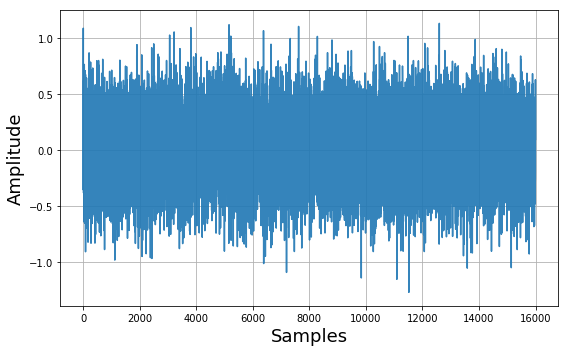

In [112]:
plt.figure()
plt.plot(data,alpha=0.9,label="Data")
plt.xlabel("Samples",fontsize=18);plt.ylabel("Amplitude",fontsize=18)
plt.tight_layout();plt.grid()
plt.show()

In [113]:
d_size = data.size
n_templates = 15 # Number of test templates

In [114]:
templates = np.zeros([n_templates,d_size])
x = np.linspace(-8000,8000,16000)

# Template widths
w = np.linspace(10,2000,n_templates) # In this case we know the min - max widths are 10-2000

# Instantiate the templates with Lorenzians of varying widths
for i in range(n_templates):
    templates[i] = Lorentzian(x,w[i])

In [115]:
freqs = np.fft.rfftfreq(d_size)

# Data fft and Power Spectrum :
data_ft = np.fft.rfft(data)
ps_data = np.abs(data_ft**2)


# Templates fft + Power spectrum :
templates_ft = np.zeros([n_templates,8001],dtype=complex)
ps_templates = np.zeros([n_templates,8001])

for i in range(n_templates):
    templates_ft[i] = np.fft.rfft(templates[i])
    ps_templates[i] = np.abs(templates_ft[i])**2

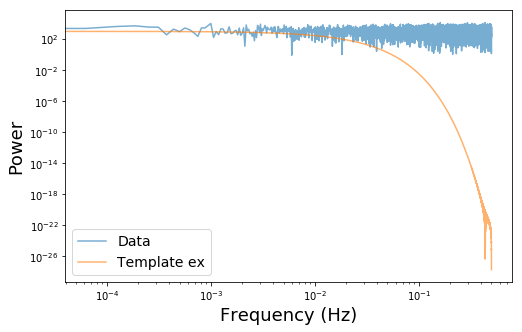

In [116]:
fig, ax = plt.subplots(1,1)
ax.loglog(freqs, ps_data, alpha=0.6, label="Data")
ax.loglog(freqs, ps_templates[0], alpha=0.6, label="Template ex")
ax.set_xlabel("Frequency (Hz)", fontsize=18);ax.set_ylabel("Power", fontsize=18)
ax.legend(fontsize=14);plt.show()

In [117]:
# Get the window from scipy.signal.windows
window = wind.hamming(d_size) #TUKEY!!!

In [118]:
# Make the windowed Hanford/Livingston data + the templates (_w = windowed)
data_ft_w = np.fft.rfft(window*data)
ps_data_w = abs(data_ft_w)**2

templates_ft_w = np.zeros(templates_ft.shape,dtype=complex)
ps_templates_w = np.zeros(ps_templates.shape)

# Templates DFT + Power spectrum
for i in range(n_templates):
    templates_ft_w[i] = np.fft.rfft(window*templates[i])
    ps_templates_w[i] = np.abs(templates_ft_w[i])**2

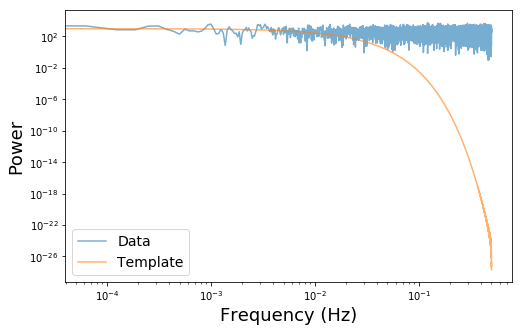

In [119]:
fig, ax = plt.subplots(1,1)
ax.loglog(freqs, ps_data_w, alpha=0.6, label="Data")
ax.loglog(freqs, ps_templates_w[0], alpha=0.6, label="Template")
ax.set_xlabel("Frequency (Hz)", fontsize=18);ax.set_ylabel("Power", fontsize=18)
ax.legend(fontsize=14);plt.show()

In [120]:
# Convolve PS with gaussian to smooth it out
ps_data_w_smooth = gaussian_filter(ps_data_w, sigma=100)

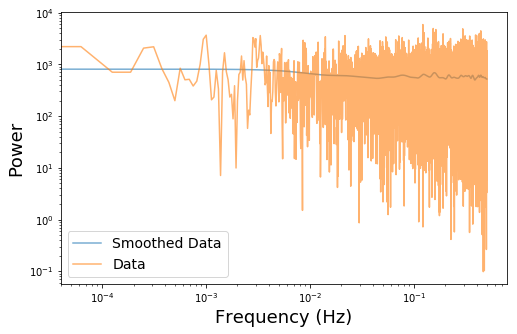

In [121]:
fig, ax = plt.subplots(1,1)
ax.loglog(freqs, ps_data_w_smooth, alpha=0.6, label="Smoothed Data")
ax.loglog(freqs, ps_data_w, alpha=0.6, label="Data")
ax.set_xlabel("Frequency (Hz)", fontsize=18);ax.set_ylabel("Power", fontsize=18)
ax.legend(fontsize=14);plt.show()

In [122]:
# N >>> Noise model
N = ps_data_w_smooth
N_inv_sqrt = 1/np.sqrt(N)

In [123]:
data_ft_whitened = N_inv_sqrt*data_ft_w
data_whitened = np.fft.irfft(data_ft_whitened, d_size)

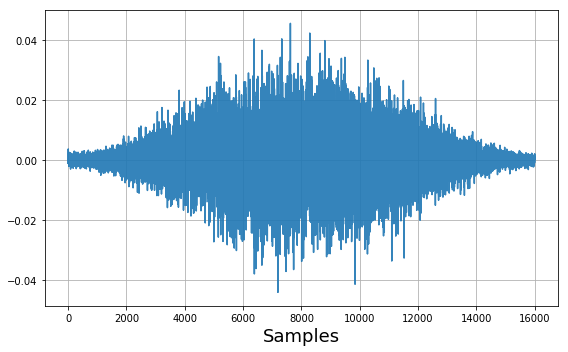

In [124]:
plt.plot(data_whitened,alpha=0.9,label="Data")
plt.xlabel("Samples",fontsize=18);
plt.tight_layout();plt.grid()
plt.show()

In [125]:
mf_ft = np.zeros(templates_ft_w.shape,dtype=complex)
mf    = np.zeros(templates.shape) 

for i in range(n_templates):
    mf_ft[i] = data_ft_whitened * np.conj(templates_ft_w[i])
    mf[i] = np.fft.irfft(mf_ft[i], d_size)

In [126]:
# Calculate SNR for each template
sigma = np.zeros([n_templates,d_size])
SNR   = np.zeros([n_templates,d_size])

for i in range(n_templates):
    sigma[i] = np.sqrt(np.mean(templates[i]**2))
    SNR[i]   = mf[i]/sigma[i]

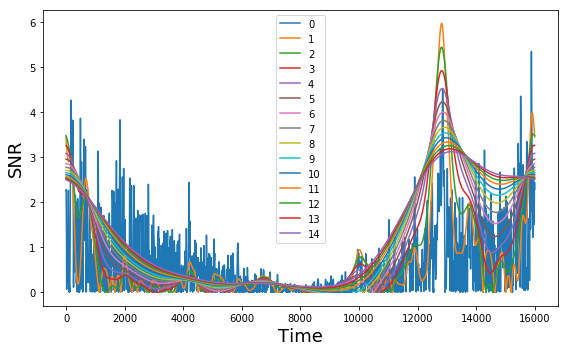

In [127]:
# If there not too many templates, plot each of the SNR's.
# Visualization of the matched filter picking out the best Lorenzian for the job.
if(n_templates<=30):
    plt.figure()
    for i in range(0,n_templates):
        plt.plot(abs(SNR[i]),label = "%d"%i)
    plt.ylabel("SNR",fontsize=18);plt.xlabel("Time",fontsize=18)
    plt.legend();plt.tight_layout();plt.show()

In [128]:
# Compute Max SNR and the time at which it occured for each template
max_SNR = np.zeros(n_templates)
time = np.zeros(n_templates)
for i in range(n_templates):
    max_SNR[i] = np.max(SNR[i])
    time[i] = np.argmax(SNR[i])

In [129]:
peaksample = d_size// 2 # location of peak in the template
indmax = int(time[np.argmax(max_SNR)])
offset = (indmax-peaksample)

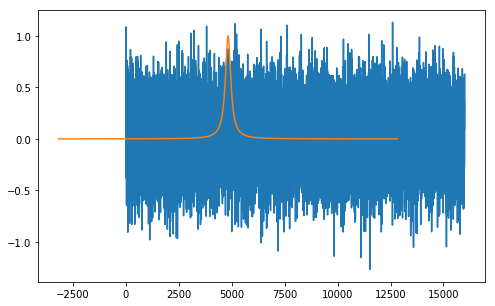

In [130]:
plt.plot(data)
plt.plot(x+offset,templates[np.argmax(max_SNR)]);plt.show()

# Gauss-Newton/Levenberg-Marquardt

In [131]:
def calc_grad(p):
    y0 = Lorentzian(x,*p)

    # Small increment used to calculate the derivative of the get_cmb function with 
    # respect to each parameter
    dx = p/10000
    grad = np.zeros([y0.size,p.size])

    grad[:,0]= ( Lorentzian(x,*(p+[dx[0],0,0])) - y0) /dx[0]
    grad[:,1]= ( Lorentzian(x,*(p+[0,dx[1],0])) - y0) /dx[1]
    grad[:,2]= ( Lorentzian(x,*(p+[0,0,dx[2]])) - y0) /dx[2]
    
    return y0,grad

In [132]:
x = np.linspace(0,16000,16000)
y = data
p0 = np.asarray([w[np.argmax(max_SNR)],offset,.5]) 

In [133]:
# Load in the initial guess at the best fit parameters
p = p0.copy()

# Calculate and plot the initial guess 
pred,grad = calc_grad(p)

Cycle   1:   χ^2 = 1461.884948391224  >>> p = [1.56828369e+02 4.82956744e+03 1.18867199e-01]
Cycle   2:   χ^2 = 1461.840242328724  >>> p = [1.09310828e+02 4.81422590e+03 1.42217970e-01]
Cycle   3:   χ^2 = 1461.802936833282  >>> p = [1.27360463e+02 4.82584320e+03 1.37988290e-01]
Cycle   4:   χ^2 = 1461.799007978060  >>> p = [1.18852811e+02 4.82303083e+03 1.43807404e-01]
Cycle   5:   χ^2 = 1461.798443603988  >>> p = [1.20784317e+02 4.82499430e+03 1.42999693e-01]
Cycle   6:   χ^2 = 1461.798379213893  >>> p = [1.19742481e+02 4.82461602e+03 1.43634604e-01]

Final parameter set: 
p   =  [1.19742481e+02 4.82461602e+03 1.43634604e-01]
σ_p =  [1.22648587e+02 8.67245060e+01 1.02672943e-01]

Matched waveform:


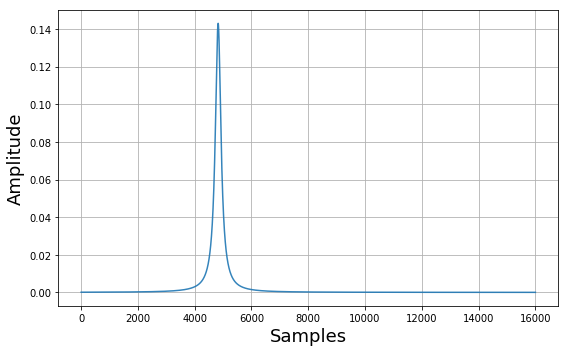

In [134]:
# Gauss-Newton/Levenberg-Marquardt loop initialization.

chisq  = 0   #
λ0     = 1e-4   # Initial value for "Damping" parameter
cycle  = 0   # Keep track of the number of cycles of the Gauss-Newton algorithim.
ε      = 1e-1

λ = λ0

d_chisq = 1

ii = 1

# Impliment the Gauss-Newton algorithm 
while(abs(d_chisq) > 0.0001):
#for i in range(200):
    cycle += 1

    pred,J = calc_grad(p)
    r = y-pred
    err = (r**2).sum()
    chisq = (((y-pred))**2).sum()

    r = np.matrix(r).T
    J = np.matrix(J)

    lhs = J.T*J + λ*np.matrix(np.diag(J.T*J))
    rhs = J.T*r

    # Calculate parameter step
    dp = np.linalg.inv(lhs)*(rhs)

    ####
    h = np.zeros(len(p))
    for i in range(p.size):
        h[i] = p[i]+dp[i]
    D = Lorentzian(x,*h)
    new_chisq = (((y-D))**2).sum()
    d_chisq = chisq - new_chisq

    # Calculate metric for step evaluation
    f = dp.T*(λ*np.matrix(np.diag(J.T*J)*dp+J.T*r))
    ρ = (d_chisq)/np.abs(f)
    if(ρ>ε):
        for i in range(p.size):
            p[i] = p[i]+dp[i]
        λ = max(λ/9,10**(-7))

    else:
         λ = min(λ*11,10**(7))
        
    if(ρ>ε):
        print("Cycle %3d: "%cycle," χ^2 = %.12f"%(new_chisq)," >>> p =",p)
    else:
        print("Cycle %3d: "%cycle," χ^2 = %.12f"%(chisq)," >>> p =",p)
    if(ii>=100):
        break
    ii+= 1

print("\nFinal parameter set: ")
print("p   = ",p)
sigma_p = np.sqrt(np.diag(np.linalg.inv(J.T*J)))
print("σ_p = ",sigma_p)
print("\nMatched waveform:")
plt.plot(x,pred,alpha=0.9, label= "Levenberg–Marquardt")    
plt.xlabel("Samples",fontsize=18);plt.ylabel("Amplitude",fontsize=18)
plt.tight_layout();plt.grid()
plt.show()

In [137]:
plt.plot(data,alpha=0.9,label="Data")
plt.plot(x,Lorentzian(x,*p),alpha=0.9,label = "Matched Lorenzian")
plt.xlabel("Samples",fontsize=18);plt.ylabel("Amplitude",fontsize=18)
plt.tight_layout();plt.grid()
plt.show()

#hanning
p =  [1.20101668e+02 4.82492957e+03 1.43423317e-01]
σ_p =  [1.21229424e+02 8.57210733e+01 1.03277131e-01]

#tukey
p =  [1.20097487e+02 4.82491560e+03 1.43426230e-01]
σ_p =  [1.21289137e+02 8.57632938e+01 1.03250741e-01]

#hamming
p =  [1.19808262e+02 4.82477684e+03 1.43600472e-01]
σ_p =  [1.21932312e+02 8.62180563e+01 1.02967610e-01]